In [29]:
import pandas as pd
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.metrics import roc_curve, auc
from sklearn.utils import resample


from lifelines import CoxPHFitter
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from lifelines.plotting import add_at_risk_counts

from nb_util import autoreload, add_dirs
add_dirs(['~/Projects/Code/ml-platform'])

# from pathai.api.monocle.slides import get_slide_info_by_slide_id
from pathai.api.slides import slides_base, slides

# Load Stellar 3-4 data with clinical covariates from the platform

In [2]:
# load st3 and st4
st3he = pd.read_excel('DATA/GILD-S-1-NASH-Stellar3_NASH_HE_Features_2022-02-22_23_33.xlsx',sheet_name='FEATURES',engine='openpyxl')
st3tc = pd.read_excel('DATA/GILD-S-1-NASH-Stellar3_NASH_Trichrome_Features_2022-02-22_23_33.xlsx',sheet_name='FEATURES',engine='openpyxl')

st4he = pd.read_excel('DATA/NASH_Stellar4_NASH_HE_Features_2022-02-23_15_58 (1).xlsx',sheet_name='FEATURES',engine='openpyxl')
st4tc = pd.read_excel('DATA/NASH_Stellar4_NASH_Trichrome_Features_2022-02-23_15_58.xlsx',sheet_name='FEATURES',engine='openpyxl')

In [3]:
st4tc = st4tc.drop(columns=['ARTIFACT_CLASSIFIER_ID','TISSUE_CLASSIFIER_ID','LARGE_SEPTAE_CLASSIFIER_ID','CRN_CLASSIFIER_ID','MPP','ORIGINAL_NAME','STAIN_NAME'])
st4he = st4he.drop(columns=['ARTIFACT_CLASSIFIER_ID','TISSUE_CLASSIFIER_ID','MPP','ORIGINAL_NAME','STAIN_NAME'])

In [4]:
all_tc = pd.concat([st3tc,st4tc])
all_he = pd.concat([st3he,st4he])

In [5]:
all_he.head(5)

,PATHAI_ID,CASE_NAME,ARTIFACT_CLASSIFIER_ID,TISSUE_CLASSIFIER_ID,MPP,ORIGINAL_NAME,STAIN_NAME,AREA (MM2) OF [ARTIFACT] IN [TISSUE]_HE,AREA (MM2) OF [BACKGROUND] IN [TISSUE]_HE,AREA (MM2) OF [USABLE TISSUE] IN [TISSUE]_HE,...,AREA PROP [[MICROVESICULAR STEATOSIS] OVER [TISSUE]] IN [TISSUE]_HE,AREA PROP [[NORMAL HEPATOCYTES] OVER [TISSUE]] IN [TISSUE]_HE,AREA PROP [[PORTAL INFLAMMATION] OVER [TISSUE]] IN [TISSUE]_HE,AREA PROP [[STEATOSIS] OVER [TISSUE]] IN [TISSUE]_HE,GNN BALLOONING_CONTINUOUS_SCORE_HE,GNN BALLOONING_SCORE_HE,GNN LOBULAR_CONTINUOUS_SCORE_HE,GNN LOBULAR_SCORE_HE,GNN STEATOSIS_CONTINUOUS_SCORE_HE,GNN STEATOSIS_SCORE_HE
0,100413,6504677216,19482.0,19578.0,0.2478,6504677216 HE.svs,H & E,5.577226,299.143316,32.964987,...,4.507337,32.985993,1.598393,20.675009,2.464039,2.0,2.249401,2.0,2.445983,2.0
1,100379,6504649028,19482.0,19578.0,0.2478,6504649028 HE.svs,H & E,4.932913,153.245393,17.326732,...,0.492603,29.342370,11.644669,23.039498,3.000000,2.0,2.701195,2.0,3.370274,3.0
2,101627,6505585507,19482.0,19578.0,0.2478,6505585507 HE.svs,H & E,2.144402,69.104520,10.707428,...,0.050942,44.929151,5.708137,6.287142,1.571571,1.0,2.208524,2.0,1.555963,1.0
3,101277,6505137236,19482.0,19578.0,0.2478,6505137236 HE.svs,H & E,2.389181,67.332928,9.910910,...,0.868360,16.412239,1.446315,42.978974,2.138197,2.0,1.953695,1.0,3.012349,3.0
4,101262,6505135847,19482.0,19578.0,0.2478,6505135847 HE.svs,H & E,2.497556,155.746348,13.632566,...,7.221331,12.446046,1.864116,19.499820,3.000000,2.0,2.490283,2.0,2.059211,2.0


## read meta data from slides API
### This can be skipped if below meta data files are available

In [334]:
slide_list = list(st3he['PATHAI_ID']) + list(st4he['PATHAI_ID'])
mdl = []
for slide in tqdm(slide_list):
    mdd = slides_base.query_from_api('slidemetadata','GET',{'slideId':slide})[0]['metadata']
    mdi = slides.get_slide_info_by_slide_id(slide)
    mdi['PATHAI_ID'] = slide
    mdi.update(mdd)
    mdl.append(mdi)
md_he = pd.DataFrame(mdl)

100%|██████████| 5042/5042 [20:12<00:00,  4.16it/s]


In [335]:
md_df_out = md_he.fillna('')
md_df_out.to_excel('DATA/Stellar3_Stellar4_slide_metadata_raw.xlsx',index=None)

In [336]:
slide_list = list(st3tc['PATHAI_ID']) + list(st4tc['PATHAI_ID'])
mdl = []
xx = 0
for slide in tqdm(slide_list):
    mdd = slides_base.query_from_api('slidemetadata','GET',{'slideId':slide})[0]['metadata']
    mdd = {k: mdd.get(k, None) for k in ['Slide Group','Case','analysis_visit','svs_filenames','usubjid','subjid','trt01a','studyid','staining']}
    mdi = slides.get_slide_info_by_slide_id(slide)
    mdi['PATHAI_ID_TC'] = slide
    mdi.update(mdd)
    mdl.append(mdi)
md_tc = pd.DataFrame(mdl)

100%|██████████| 5030/5030 [20:58<00:00,  4.00it/s]


In [337]:
md_tc_out = md_tc.fillna('')
md_tc_out.to_excel('DATA/Stellar3_Stellar4_TC_metadata_compliment.xlsx',index=None)

In [542]:
md_df_out['ishsc_bl']

0       3.0
1         4
2          
3         1
4         2
       ... 
5037    6.0
5038    6.0
5039    6.0
5040       
5041    2.0
Name: ishsc_bl, Length: 5042, dtype: object

## load local meta data files

In [6]:
# manually remove many mostly empty columns from the HE metadata
mdf = pd.read_excel('DATA/Stellar3_Stellar4_slide_metadata_sellect.xlsx',engine='openpyxl')
md_tc = pd.read_excel('DATA/Stellar3_Stellar4_TC_metadata_compliment.xlsx',engine='openpyxl')

In [9]:
add_cols = [
    'ishsc_bl',
    'fibsg_bl',
    'steatc_bl',
    'nashb_bl',
    'nasli_bl',
   'nas_bl']

In [83]:
mdf[['slideGroupName','studyid']].value_counts()

slideGroupName  studyid       
NASH_Stellar4   GS-US-384-1944    2471
NASH_Stellar3   GS-US-384-1943    2172
NASH_Stellar4   GS-US-384-1943     276
NASH_Stellar3   GS-US-384-1944      35
                GS-US-454-4378      13
NASH_Stellar4   GS-US-454-4378      10
dtype: int64

from the study protocol listed on clinical trials dot gov, we see the assignment:
- Stellar4: GS-US-384-1944
- Stellar3: GS-US-384-1943
- GS-US-454-4378: study in bridging fibrosis

# Sellect clinical columns and begin analysis

BL nits to compare:
    - fib4_bl
    - fgluc_bl
    - elfscore_bl
    - fibscan_bl
    - fbtstscr_bl

Subject at baseline:
    - weight
    - diabetus

Other path to compare:
    - ishsc_bl 

In [10]:
clin_cols = ['t2cem_aval','t2cem_cnsr','fib4_bl','fgluc_bl','elfscore_bl','fibscan_bl','fbtstscr_bl']+add_cols
md_all = mdf.merge(md_tc,how='inner',on=['usubjid','subjid','trt01a','studyid','analysis_visit'], suffixes = (None, '_TC'))
md_all = md_all[['PATHAI_ID','PATHAI_ID_TC','usubjid','subjid','trt01a','studyid','slideGroupName','analysis_visit']+clin_cols].drop_duplicates()

In [11]:
whe = md_all.merge(all_he,how='left',on='PATHAI_ID').drop_duplicates()
all_tc_working = all_tc.rename(columns = {'PATHAI_ID':'PATHAI_ID_TC'})
whe = whe.merge(all_tc_working,how='left',on='PATHAI_ID_TC', suffixes=(None,'_TC')).drop_duplicates()

# Stellar 3

In [12]:
study_mask = whe['studyid']=='GS-US-384-1943'
whe[study_mask]['usubjid'].nunique()

1607

In [13]:
whe.loc[study_mask,'analysis_visit'].value_counts()

Baseline    2035
Week 48      728
Name: analysis_visit, dtype: int64

In [14]:
# filter for analysis
study_mask = whe['studyid'] == 'GS-US-384-1943'
# case_mask = whe['CASE_NAME'] == whe['CASE_NAME_TC'] # excludes where both are NaN
time_mask = whe['analysis_visit'] == 'Baseline'
st3_case = whe[study_mask & time_mask].copy()

In [15]:
# filter for analysis
study_mask = whe['studyid'] == 'GS-US-384-1944'
# case_mask = whe['CASE_NAME'] == whe['CASE_NAME_TC'] # excludes where both are NaN
time_mask = whe['analysis_visit'] == 'Baseline'
st4_case = whe[study_mask & time_mask].copy()

In [16]:
study_mask = st3_case['studyid']=='GS-US-384-1943'
st3_case[study_mask]['usubjid'].nunique()

1580

In [17]:
# group by subject and keep largest area on HE+TC
def clean_case(df):
    
    case_mask = df['CASE_NAME'] == df['CASE_NAME_TC']
    
    if any(case_mask):
        df = df[case_mask]
    
    tte_mask = df['t2cem_aval'].notna()
    if any(tte_mask):
        df = df[tte_mask]
    else:
        return None
        
    if len(df) == 1:
        return df
    else:
        tmp_area = (df['AREA (MM2) OF [USABLE TISSUE] IN [TISSUE]_TRICHROME'] + df['AREA (MM2) OF [USABLE TISSUE] IN [TISSUE]_HE']).values
        max_area = np.max(tmp_area)
        max_mask = tmp_area == max_area
        if np.sum(max_mask*1)==1:
            return df.iloc[max_mask,:]
        else:
            #if areas are the same, just return the first one
            return df.iloc[[0],:]

st3_case_clean = st3_case.groupby('usubjid').apply(clean_case).reset_index(drop=True)
st4_case_clean = st4_case.groupby('usubjid').apply(clean_case).reset_index(drop=True)

In [18]:
len(st3_case_clean)

725

In [19]:
len(st4_case_clean)

794

In [20]:
# check NAS
np.all(np.isclose(st3_case_clean[['steatc_bl','nashb_bl','nasli_bl']].sum(axis=1).values, st3_case_clean['nas_bl'].values))

True

# STELLAR 3 POC

In [22]:
st3_case_clean['trt01a'].value_counts(dropna=False)

SEL 18 mg + Placebo 6 mg        294
SEL 6 mg + Placebo 18 mg        289
Placebo 6 mg + Placebo 18 mg    142
Name: trt01a, dtype: int64

In [23]:
trts = ['SEL 18 mg + Placebo 6 mg','SEL 6 mg + Placebo 18 mg','Placebo 6 mg + Placebo 18 mg']
kms = []
df = st3_case_clean.copy()
time_col = 't2cem_aval'
cens_col = 't2cem_cnsr'

for ii, trt in enumerate(trts):
    trt_mask = df['trt01a']==trt
    km = KaplanMeierFitter() 
    km.fit(df[trt_mask][time_col], 1-df[trt_mask][cens_col], label=trt)
    if ii==0:
        ax = km.plot(ci_show=True, show_censors=True)
    else:
        ax = km.plot(ax=ax, ci_show=True, show_censors=True)
    kms.append(km)
    
add_at_risk_counts(kms[0], kms[1],kms[2], ax=ax)

plt.show()

/Users/charles.biddle.snead/opt/miniconda3/envs/sp/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


In [24]:
df = st3_case_clean.copy()
time_col = 't2cem_aval'
cens_col = 't2cem_cnsr'

mfu = np.median(df[df[cens_col]==1][time_col])
print(mfu)
print((df[df[cens_col]==0][time_col]<=16.5).value_counts())
len(df[time_col])

16.52566735
True    108
Name: t2cem_aval, dtype: int64


725

In [25]:
108/725

0.1489655172413793

In [26]:
df = st4_case_clean.copy()
time_col = 't2cem_aval'
cens_col = 't2cem_cnsr'

mfu = np.median(df[df[cens_col]==1][time_col])
print(mfu)
print((df[df[cens_col]==0][time_col]<=15.8).value_counts())
len(df[time_col])

15.885010265
True     20
False     2
Name: t2cem_aval, dtype: int64


794

In [27]:
20/794

0.02518891687657431

2.551270859598992e-08


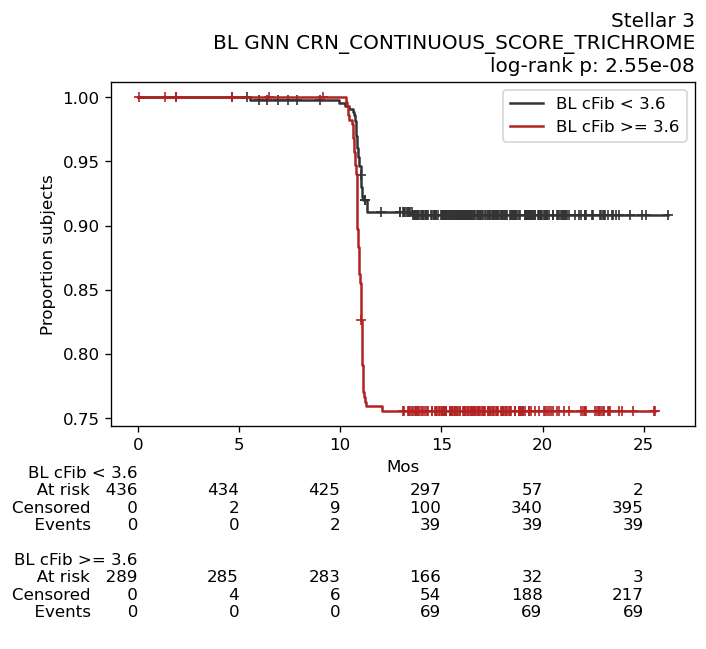

In [31]:
cs = {0.0: ".2", 1.0: "firebrick"}
co = 3.6
hif_refs = {'GNN CRN_CONTINUOUS_SCORE_TRICHROME':co}
df = st3_case_clean.copy()
# df = df[df['GNN CRN_CONTINUOUS_SCORE_TRICHROME']<4]
time_col = 't2cem_aval'
cens_col = 't2cem_cnsr'
hif = 'GNN CRN_CONTINUOUS_SCORE_TRICHROME'
df = df[[time_col,cens_col,hif]].dropna()

coval = hif_refs['GNN CRN_CONTINUOUS_SCORE_TRICHROME']
pos_mask = df[hif] >= coval
neg_mask = df[hif] < coval 

fig = plt.figure(figsize=(6, 5), dpi=120)

km1 = KaplanMeierFitter() 
km1.fit(df[neg_mask][time_col], 1-df[neg_mask][cens_col], label=f'BL cFib < {np.around(coval,2)}')
ax = km1.plot(ci_show=False, show_censors=True, censor_styles = {'ms': 6}, color=cs[0])

km2= KaplanMeierFitter() 
km2.fit(df[pos_mask][time_col], 1-df[pos_mask][cens_col], label=f'BL cFib >= {np.around(coval,2)}')
ax = km2.plot(ax = ax, ci_show=False, show_censors=True, censor_styles = {'ms': 6},color=cs[1])

results=logrank_test(
    df[neg_mask][time_col],df[pos_mask][time_col],event_observed_A=1-df[neg_mask][cens_col], event_observed_B = 1-df[pos_mask][cens_col])
# results.print_summary()
print(results.p_value) 

add_at_risk_counts(km1, km2, ax=ax)

ax.set_title(f'Stellar 3\nBL {hif}\nlog-rank p: {results.p_value:.2e}',loc='right')
ax.set_xlabel('Mos')
ax.set_ylabel('Proportion subjects')
plt.show()



In [33]:
df['BL cFib < 3.6'] = df['GNN CRN_CONTINUOUS_SCORE_TRICHROME']<3.6
df.to_csv("DATA/km_plot_data_st3.csv")

0.4795537927020309


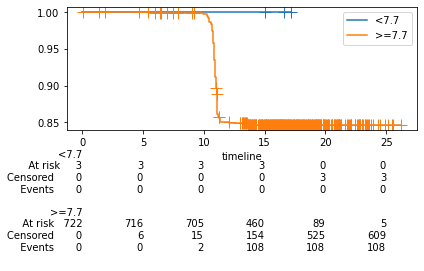

2.6651108461230705e-08


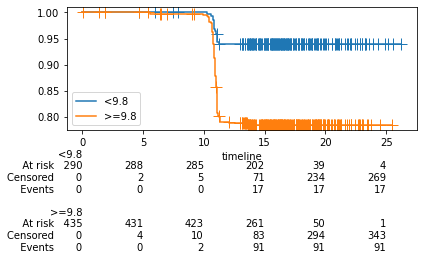

9.167390313239208e-08


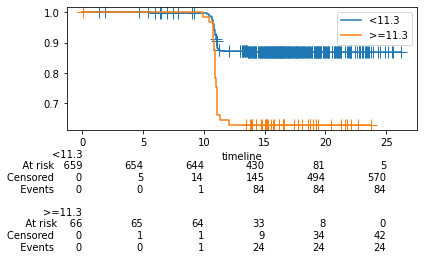

In [53]:
for co  in [7.7,9.8,11.3]:
    hif = 'elfscore_bl'
    hif_refs = {'elfscore_bl':co}
    df = st3_case_clean.copy()
    # df = df[df['GNN CRN_CONTINUOUS_SCORE_TRICHROME']<4]
    time_col = 't2cem_aval'
    cens_col = 't2cem_cnsr'

    df = df[[time_col,cens_col,hif]].dropna()

    coval = hif_refs['elfscore_bl']
    pos_mask = df[hif] >= coval
    neg_mask = df[hif] < coval 

    km1 = KaplanMeierFitter() 
    km1.fit(df[neg_mask][time_col], 1-df[neg_mask][cens_col], label=f'<{np.around(coval,2)}')
    ax = km1.plot(ci_show=False, show_censors=True)

    km2= KaplanMeierFitter() 
    km2.fit(df[pos_mask][time_col], 1-df[pos_mask][cens_col], label=f'>={np.around(coval,2)}')
    ax = km2.plot(ax = ax, ci_show=False, show_censors=True)

    results=logrank_test(
        df[neg_mask][time_col],df[pos_mask][time_col],event_observed_A=1-df[neg_mask][cens_col], event_observed_B = 1-df[pos_mask][cens_col])
    # results.print_summary()
    print(results.p_value) 

    add_at_risk_counts(km1, km2, ax=ax)

    plt.show()

# STELLAR 4 POC

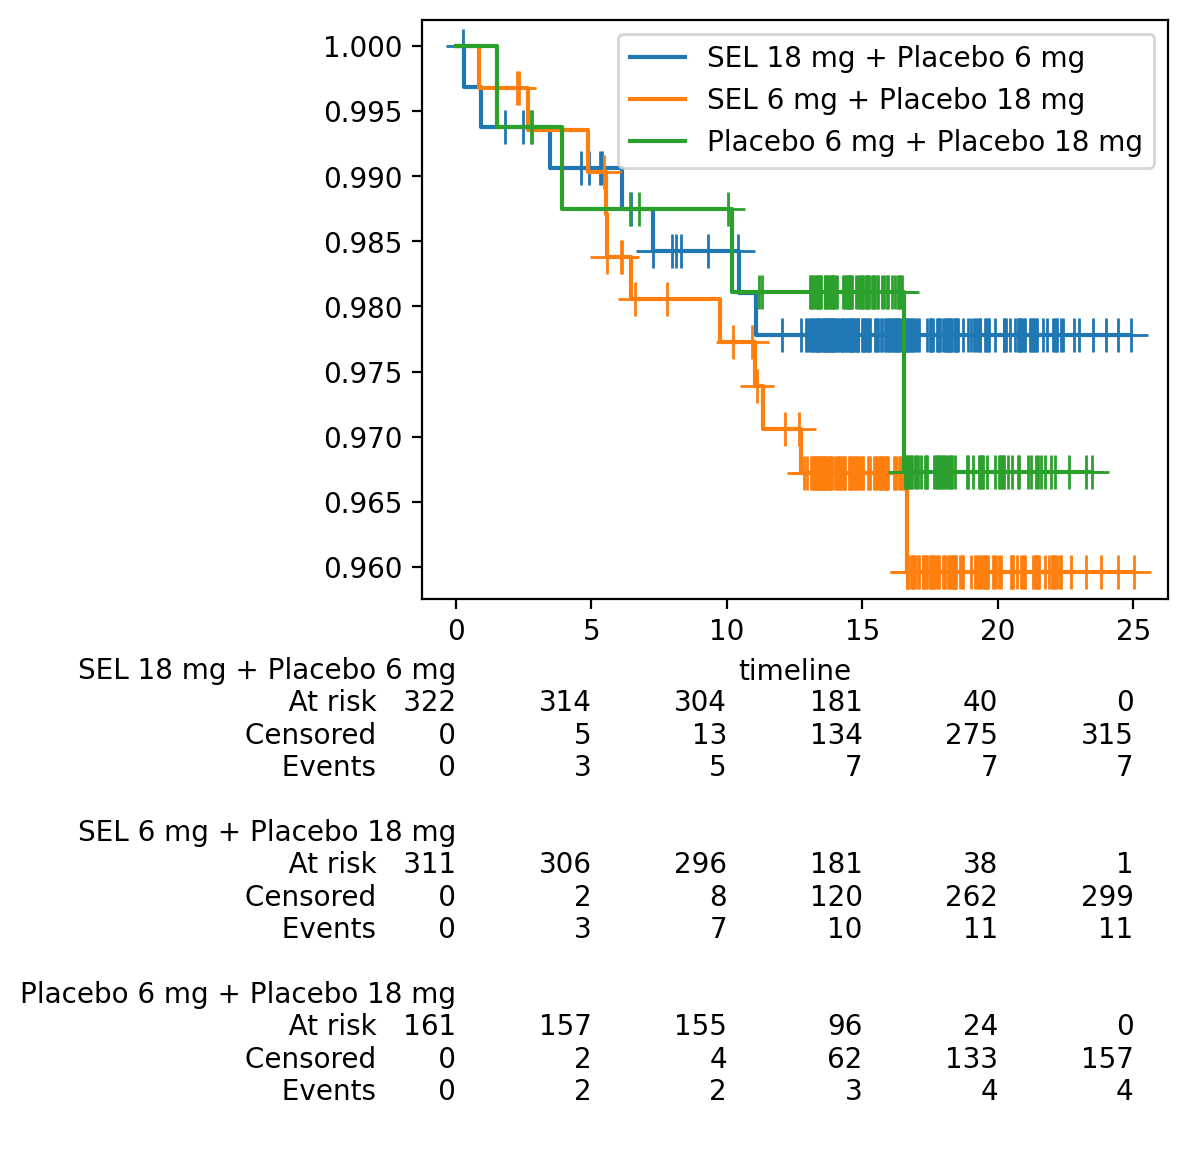

In [36]:
trts = ['SEL 18 mg + Placebo 6 mg','SEL 6 mg + Placebo 18 mg','Placebo 6 mg + Placebo 18 mg']
kms = []
df = st4_case_clean.copy()
time_col = 't2cem_aval'
cens_col = 't2cem_cnsr'
fig = plt.figure(figsize=(6, 6), dpi=200)
for ii, trt in enumerate(trts):
    trt_mask = df['trt01a']==trt
    km = KaplanMeierFitter() 
    km.fit(df[trt_mask][time_col], 1-df[trt_mask][cens_col], label=trt)
    if ii==0:
        ax = km.plot(ci_show=False, show_censors=True)
    else:
        ax = km.plot(ax=ax, ci_show=False, show_censors=True)
    kms.append(km)
    
add_at_risk_counts(kms[0], kms[1],kms[2], ax=ax)

plt.show()

0.027924634136255313


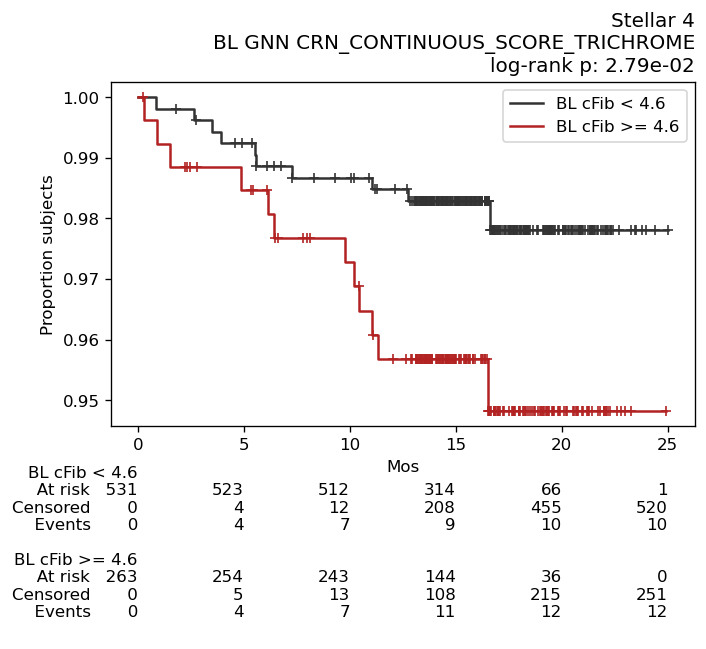

In [37]:
co = 4.6
hif_refs = {'GNN CRN_CONTINUOUS_SCORE_TRICHROME':co}
df = st4_case_clean.copy()
# df = df[df['GNN CRN_CONTINUOUS_SCORE_TRICHROME']<4]
time_col = 't2cem_aval'
cens_col = 't2cem_cnsr'
hif = 'GNN CRN_CONTINUOUS_SCORE_TRICHROME'
df = df[[time_col,cens_col,hif]].dropna()

coval = hif_refs['GNN CRN_CONTINUOUS_SCORE_TRICHROME']
pos_mask = df[hif] >= coval
neg_mask = df[hif] < coval 
fig = plt.figure(figsize=(6, 5), dpi=120)

km1 = KaplanMeierFitter() 
km1.fit(df[neg_mask][time_col], 1-df[neg_mask][cens_col], label=f'BL cFib < {np.around(coval,2)}')
ax = km1.plot(ci_show=False, show_censors=True, censor_styles = {'ms': 6}, color=cs[0])

km2= KaplanMeierFitter() 
km2.fit(df[pos_mask][time_col], 1-df[pos_mask][cens_col], label=f'BL cFib >= {np.around(coval,2)}')
ax = km2.plot(ax = ax, ci_show=False, show_censors=True, censor_styles = {'ms': 6},color=cs[1])

results=logrank_test(
    df[neg_mask][time_col],df[pos_mask][time_col],event_observed_A=1-df[neg_mask][cens_col], event_observed_B = 1-df[pos_mask][cens_col])
# results.print_summary()
print(results.p_value) 

add_at_risk_counts(km1, km2, ax=ax)

ax.set_title(f'Stellar 4\nBL {hif}\nlog-rank p: {results.p_value:.2e}',loc='right')
ax.set_xlabel('Mos')
ax.set_ylabel('Proportion subjects')
plt.show()

In [38]:
df['BL cFib < 4.6'] = df['GNN CRN_CONTINUOUS_SCORE_TRICHROME']<4.6
df.to_csv("DATA/km_plot_data_st4.csv")

0.03065784302865703


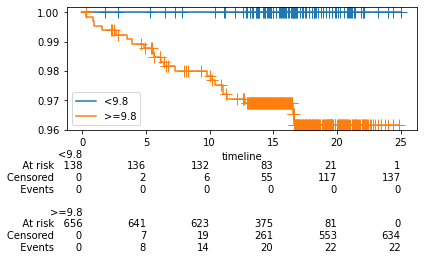

9.619618541456815e-09


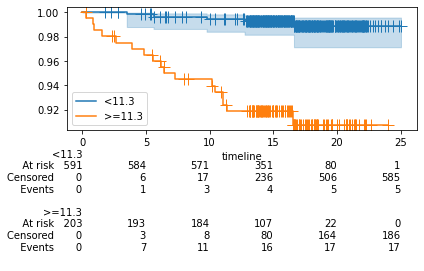

In [408]:
for co  in [9.8,11.3]:
    hif = 'elfscore_bl'
    hif_refs = {'elfscore_bl':co}
    df = st4_case_clean.copy()
    # df = df[df['GNN CRN_CONTINUOUS_SCORE_TRICHROME']<4]
    time_col = 't2cem_aval'
    cens_col = 't2cem_cnsr'

    df = df[[time_col,cens_col,hif]].dropna()

    coval = hif_refs['elfscore_bl']
    pos_mask = df[hif] >= coval
    neg_mask = df[hif] < coval 

    km1 = KaplanMeierFitter() 
    km1.fit(df[neg_mask][time_col], 1-df[neg_mask][cens_col], label=f'<{np.around(coval,2)}')
    ax = km1.plot(ci_show=True, show_censors=True)

    km2= KaplanMeierFitter() 
    km2.fit(df[pos_mask][time_col], 1-df[pos_mask][cens_col], label=f'>={np.around(coval,2)}')
    ax = km2.plot(ax = ax, ci_show=False, show_censors=True)

    results=logrank_test(
        df[neg_mask][time_col],df[pos_mask][time_col],event_observed_A=1-df[neg_mask][cens_col], event_observed_B = 1-df[pos_mask][cens_col])
    # results.print_summary()
    print(results.p_value) 

    add_at_risk_counts(km1, km2, ax=ax)

    plt.show()

GNN CRN_CONTINUOUS_SCORE_TRICHROME 725
GNN CRN_CONTINUOUS_SCORE_TRICHROME auc 0.6666614309275112
elfscore_bl 725
elfscore_bl auc 0.6954134924998034


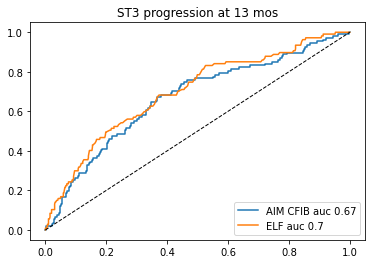

In [454]:
hif = 'GNN CRN_CONTINUOUS_SCORE_TRICHROME'
hif_refs = {'GNN CRN_CONTINUOUS_SCORE_TRICHROME':co}
df = st3_case_clean.copy()
# df = df[df['GNN CRN_CONTINUOUS_SCORE_TRICHROME']<4]
time_col = 't2cem_aval'
cens_col = 't2cem_cnsr'

df = df[[time_col,cens_col,hif]].dropna()
print(hif, len(df))
at_time = 13
df = df[~((df[time_col] <= at_time) & (df[cens_col]))]
target_pos_mask = (df[time_col] <= at_time) & (1-df[cens_col])
target_neg_mask = !target_pos_mask

fpr, tpr, thresholds = roc_curve(1*target_pos_mask,df[hif])

fig = plt.figure()
ax = plt.plot(fpr,tpr,label=f'AIM CFIB auc {np.around(auc(fpr,tpr),2)}')
print(hif,'auc',auc(fpr,tpr))

hif = 'elfscore_bl'
hif_refs = {'elfscore_bl':co}
df = st3_case_clean.copy()
# df = df[df['GNN CRN_CONTINUOUS_SCORE_TRICHROME']<4]
time_col = 't2cem_aval'
cens_col = 't2cem_cnsr'

df = df[[time_col,cens_col,hif]].dropna()
print(hif, len(df))
df = df[~((df[time_col] <= at_time) & (df[cens_col]))]
target_pos_mask = (df[time_col] <= at_time) & (1-df[cens_col])
target_neg_mask = !target_pos_mask

fpr, tpr, thresholds = roc_curve(1*target_pos_mask,df[hif])

ax = plt.plot(fpr,tpr,label=f'ELF auc {np.around(auc(fpr,tpr),2)}')
plt.plot([0,1],[0,1],ls='--',lw=1,c='0')
plt.legend(loc="lower right")
plt.title(f'ST3 progression at {at_time} mos')
print(hif,'auc',auc(fpr,tpr))

GNN CRN_CONTINUOUS_SCORE_TRICHROME 725
GNN CRN_CONTINUOUS_SCORE_TRICHROME auc 0.6666614309275112
ishsc_bl 725
ishsc_bl auc 0.5740202623105317


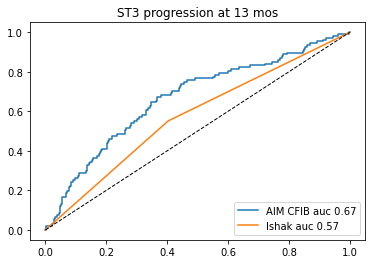

In [56]:
hif = 'GNN CRN_CONTINUOUS_SCORE_TRICHROME'
hif_refs = {'GNN CRN_CONTINUOUS_SCORE_TRICHROME':co}
df = st3_case_clean.copy()
# df = df[df['GNN CRN_CONTINUOUS_SCORE_TRICHROME']<4]
time_col = 't2cem_aval'
cens_col = 't2cem_cnsr'

df = df[[time_col,cens_col,hif]].dropna()
print(hif, len(df))
at_time = 13
df = df[~((df[time_col] <= at_time) & (df[cens_col]))]
target_pos_mask = (df[time_col] <= at_time) & (1-df[cens_col])
target_neg_mask = !target_pos_mask

fpr, tpr, thresholds = roc_curve(1*target_pos_mask,df[hif])

fig = plt.figure()
ax = plt.plot(fpr,tpr,label=f'AIM CFIB auc {np.around(auc(fpr,tpr),2)}')
print(hif,'auc',auc(fpr,tpr))

hif = 'ishsc_bl'
hif_refs = {'ishsc_bl':co}
df = st3_case_clean.copy()
# df = df[df['GNN CRN_CONTINUOUS_SCORE_TRICHROME']<4]
time_col = 't2cem_aval'
cens_col = 't2cem_cnsr'

df = df[[time_col,cens_col,hif]].dropna()
print(hif, len(df))
df = df[~((df[time_col] <= at_time) & (df[cens_col]))]
target_pos_mask = (df[time_col] <= at_time) & (1-df[cens_col])
target_neg_mask = !target_pos_mask

fpr, tpr, thresholds = roc_curve(1*target_pos_mask,df[hif])

ax = plt.plot(fpr,tpr,label=f'Ishak auc {np.around(auc(fpr,tpr),2)}')
plt.plot([0,1],[0,1],ls='--',lw=1,c='0')
plt.legend(loc="lower right")
plt.title(f'ST3 progression at {at_time} mos')
print(hif,'auc',auc(fpr,tpr))

GNN CRN_CONTINUOUS_SCORE_TRICHROME 794
GNN CRN_CONTINUOUS_SCORE_TRICHROME auc 0.6078551912568305
fib4_bl 792
fib4_bl auc 0.8021815825473395


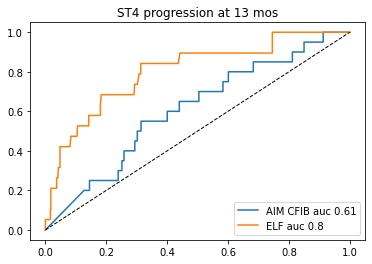

In [455]:
hif = 'GNN CRN_CONTINUOUS_SCORE_TRICHROME'
hif_refs = {'GNN CRN_CONTINUOUS_SCORE_TRICHROME':co}
df = st4_case_clean.copy()
# df = df[df['GNN CRN_CONTINUOUS_SCORE_TRICHROME']<4]
time_col = 't2cem_aval'
cens_col = 't2cem_cnsr'

df = df[[time_col,cens_col,hif]].dropna()
print(hif, len(df))

at_time = 13
df = df[~((df[time_col] <= at_time) & (df[cens_col]))]
target_pos_mask = (df[time_col] <= at_time) & (1-df[cens_col])
target_neg_mask = !target_pos_mask

fpr, tpr, thresholds = roc_curve(1*target_pos_mask,df[hif])

fig = plt.figure()
ax = plt.plot(fpr,tpr,label=f'AIM CFIB auc {np.around(auc(fpr,tpr),2)}')
print(hif,'auc',auc(fpr,tpr))

hif = 'elfscore_bl'
hif_refs = {'elfscore_bl':co}
df = st4_case_clean.copy()
# df = df[df['GNN CRN_CONTINUOUS_SCORE_TRICHROME']<4]
time_col = 't2cem_aval'
cens_col = 't2cem_cnsr'

df = df[[time_col,cens_col,hif]].dropna()
print(hif, len(df))
df = df[~((df[time_col] <= at_time) & (df[cens_col]))]
target_pos_mask = (df[time_col] <= at_time) & (1-df[cens_col])
target_neg_mask = !target_pos_mask

fpr, tpr, thresholds = roc_curve(1*target_pos_mask,df[hif])

ax = plt.plot(fpr,tpr,label=f'ELF auc {np.around(auc(fpr,tpr),2)}')
plt.plot([0,1],[0,1],ls='--',lw=1,c='0')
plt.legend(loc="lower right")
plt.title(f'ST4 progression at {at_time} mos')
print(hif,'auc',auc(fpr,tpr))

GNN CRN_CONTINUOUS_SCORE_TRICHROME 794
GNN CRN_CONTINUOUS_SCORE_TRICHROME auc 0.6078551912568305
ishsc_bl 794
ishsc_bl auc 0.6543032786885246


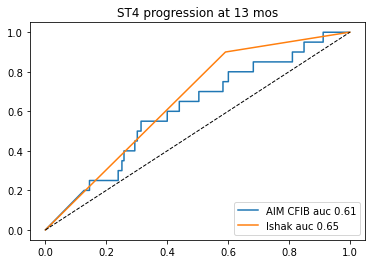

In [57]:
hif = 'GNN CRN_CONTINUOUS_SCORE_TRICHROME'
hif_refs = {'GNN CRN_CONTINUOUS_SCORE_TRICHROME':co}
df = st4_case_clean.copy()
# df = df[df['GNN CRN_CONTINUOUS_SCORE_TRICHROME']<4]
time_col = 't2cem_aval'
cens_col = 't2cem_cnsr'

df = df[[time_col,cens_col,hif]].dropna()
print(hif, len(df))

at_time = 13
df = df[~((df[time_col] <= at_time) & (df[cens_col]))]
target_pos_mask = (df[time_col] <= at_time) & (1-df[cens_col])
target_neg_mask = !target_pos_mask

fpr, tpr, thresholds = roc_curve(1*target_pos_mask,df[hif])

fig = plt.figure()
ax = plt.plot(fpr,tpr,label=f'AIM CFIB auc {np.around(auc(fpr,tpr),2)}')
print(hif,'auc',auc(fpr,tpr))

hif = 'ishsc_bl'
hif_refs = {'ishsc_bl':co}
df = st4_case_clean.copy()
# df = df[df['GNN CRN_CONTINUOUS_SCORE_TRICHROME']<4]
time_col = 't2cem_aval'
cens_col = 't2cem_cnsr'

df = df[[time_col,cens_col,hif]].dropna()
print(hif, len(df))
df = df[~((df[time_col] <= at_time) & (df[cens_col]))]
target_pos_mask = (df[time_col] <= at_time) & (1-df[cens_col])
target_neg_mask = !target_pos_mask

fpr, tpr, thresholds = roc_curve(1*target_pos_mask,df[hif])

ax = plt.plot(fpr,tpr,label=f'Ishak auc {np.around(auc(fpr,tpr),2)}')
plt.plot([0,1],[0,1],ls='--',lw=1,c='0')
plt.legend(loc="lower right")
plt.title(f'ST4 progression at {at_time} mos')
print(hif,'auc',auc(fpr,tpr))

GNN CRN_CONTINUOUS_SCORE_TRICHROME 794
GNN CRN_CONTINUOUS_SCORE_TRICHROME auc 0.6078551912568305
GNN BALLOONING_CONTINUOUS_SCORE_HE 794
GNN BALLOONING_CONTINUOUS_SCORE_HE auc 0.5555327868852459
GNN LOBULAR_CONTINUOUS_SCORE_HE 794
GNN LOBULAR_CONTINUOUS_SCORE_HE auc 0.523292349726776
GNN STEATOSIS_CONTINUOUS_SCORE_HE 794
GNN STEATOSIS_CONTINUOUS_SCORE_HE auc 0.3823087431693989


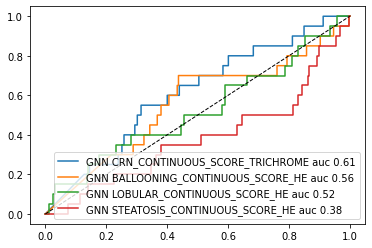

In [462]:
hifs = [
    'GNN CRN_CONTINUOUS_SCORE_TRICHROME',
    'GNN BALLOONING_CONTINUOUS_SCORE_HE',
       'GNN LOBULAR_CONTINUOUS_SCORE_HE',
       'GNN STEATOSIS_CONTINUOUS_SCORE_HE']
fig = plt.figure()

for hif in hifs:

    df = st4_case_clean.copy()

    time_col = 't2cem_aval'
    cens_col = 't2cem_cnsr'

    df = df[[time_col,cens_col,hif]].dropna()
    print(hif, len(df))

    at_time = 13
    df = df[~((df[time_col] <= at_time) & (df[cens_col]))]
    target_pos_mask = (df[time_col] <= at_time) & (1-df[cens_col])
    target_neg_mask = !target_pos_mask

    fpr, tpr, thresholds = roc_curve(1*target_pos_mask,df[hif])

    ax = plt.plot(fpr,tpr,label=f'{hif} auc {np.around(auc(fpr,tpr),2)}')
    print(hif,'auc',auc(fpr,tpr))
    
plt.plot([0,1],[0,1],ls='--',lw=1,c='0')    
plt.legend(loc="lower right")

GNN CRN_CONTINUOUS_SCORE_TRICHROME 725
GNN CRN_CONTINUOUS_SCORE_TRICHROME auc 0.6666614309275112
GNN BALLOONING_CONTINUOUS_SCORE_HE 725
GNN BALLOONING_CONTINUOUS_SCORE_HE auc 0.5514646980287442
GNN LOBULAR_CONTINUOUS_SCORE_HE 725
GNN LOBULAR_CONTINUOUS_SCORE_HE auc 0.48976674782062357
GNN STEATOSIS_CONTINUOUS_SCORE_HE 725
GNN STEATOSIS_CONTINUOUS_SCORE_HE auc 0.43430456294667397


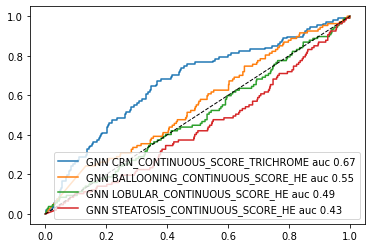

In [463]:
hifs = [
    'GNN CRN_CONTINUOUS_SCORE_TRICHROME',
    'GNN BALLOONING_CONTINUOUS_SCORE_HE',
   'GNN LOBULAR_CONTINUOUS_SCORE_HE',
   'GNN STEATOSIS_CONTINUOUS_SCORE_HE']
fig = plt.figure()

for hif in hifs:

    df = st3_case_clean.copy()

    time_col = 't2cem_aval'
    cens_col = 't2cem_cnsr'

    df = df[[time_col,cens_col,hif]].dropna()
    print(hif, len(df))

    at_time = 13
    df = df[~((df[time_col] <= at_time) & (df[cens_col]))]
    target_pos_mask = (df[time_col] <= at_time) & (1-df[cens_col])
    target_neg_mask = !target_pos_mask

    fpr, tpr, thresholds = roc_curve(1*target_pos_mask,df[hif])

    ax = plt.plot(fpr,tpr,label=f'{hif} auc {np.around(auc(fpr,tpr),2)}')
    print(hif,'auc',auc(fpr,tpr))
    
plt.plot([0,1],[0,1],ls='--',lw=1,c='0')    
plt.legend(loc="lower right")

GNN CRN_CONTINUOUS_SCORE_TRICHROME 725
GNN CRN_CONTINUOUS_SCORE_TRICHROME auc 0.66 ( 0.6 , 0.71 )
GNN CRN_SCORE_TRICHROME 725
GNN CRN_SCORE_TRICHROME auc 0.59 ( 0.55 , 0.63 )


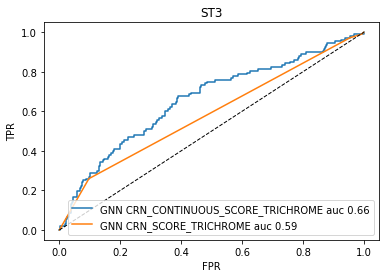

In [51]:
hifs = [
    'GNN CRN_CONTINUOUS_SCORE_TRICHROME',
    'GNN CRN_SCORE_TRICHROME']
fig = plt.figure()

data_out = []

for hif in hifs:

    df = st3_case_clean.copy()

    time_col = 't2cem_aval'
    cens_col = 't2cem_cnsr'

    df = df[[time_col,cens_col,hif]].dropna()
    print(hif, len(df))

    at_time = 16.5
    df = df[~((df[time_col] <= at_time) & (df[cens_col]))]
    target_pos_mask = (df[time_col] <= at_time) & (1-df[cens_col])
    target_neg_mask = !target_pos_mask

    fpr, tpr, thresholds = roc_curve(1*target_pos_mask,df[hif])
    hif_vals = df[hif].copy()
    
    auc_bs = []
    for i_bs in range(1000):
        tpm_bs, hif_bs = resample(target_pos_mask, hif_vals)
        fpr_bs, tpr_bs, _ = roc_curve(1*tpm_bs,hif_bs)
        auc_bs.append(auc(fpr_bs,tpr_bs))
    
    auc_ci = np.percentile(auc_bs,[5,95])
    
    ax = plt.plot(fpr,tpr,label=f'{hif} auc {np.around(auc(fpr,tpr),2)}')
    print(hif,'auc',np.around(auc(fpr,tpr),2),'(',np.around(auc_ci[0],2),',',np.around(auc_ci[1],2),')')
    data_out.append(pd.DataFrame({'HIF':hif, 
                     'FPR':fpr, 
                     'TPR':tpr}))
    
plt.plot([0,1],[0,1],ls='--',lw=1,c='0')    
plt.legend(loc="lower right")
plt.title('ST3')
plt.xlabel('FPR')
plt.ylabel('TPR')

df_out = pd.concat(data_out)

In [52]:
df_out.to_csv('DATA/roc_plot_st3.csv')

GNN CRN_CONTINUOUS_SCORE_TRICHROME 794
GNN CRN_CONTINUOUS_SCORE_TRICHROME auc 0.61 ( 0.51 , 0.71 )
GNN CRN_SCORE_TRICHROME 794
GNN CRN_SCORE_TRICHROME auc 0.54 ( 0.47 , 0.59 )


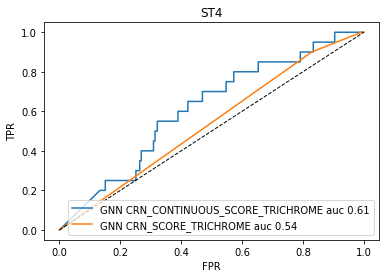

In [53]:
hifs = [
    'GNN CRN_CONTINUOUS_SCORE_TRICHROME',
    'GNN CRN_SCORE_TRICHROME']
fig = plt.figure()
data_out = []
for hif in hifs:

    df = st4_case_clean.copy()

    time_col = 't2cem_aval'
    cens_col = 't2cem_cnsr'

    df = df[[time_col,cens_col,hif]].dropna()
    print(hif, len(df))

    at_time = 15.8
    df = df[~((df[time_col] <= at_time) & (df[cens_col]))]
    target_pos_mask = (df[time_col] <= at_time) & (1-df[cens_col])
    target_neg_mask = !target_pos_mask

    fpr, tpr, thresholds = roc_curve(1*target_pos_mask,df[hif])
    hif_vals = df[hif].copy()
    
    auc_bs = []
    for i_bs in range(1000):
        tpm_bs, hif_bs = resample(target_pos_mask, hif_vals)
        fpr_bs, tpr_bs, _ = roc_curve(1*tpm_bs,hif_bs)
        auc_bs.append(auc(fpr_bs,tpr_bs))
    
    auc_ci = np.percentile(auc_bs,[5,95])
    
    ax = plt.plot(fpr,tpr,label=f'{hif} auc {np.around(auc(fpr,tpr),2)}')
    print(hif,'auc',np.around(auc(fpr,tpr),2),'(',np.around(auc_ci[0],2),',',np.around(auc_ci[1],2),')')
    data_out.append(pd.DataFrame({'HIF':hif, 
                     'FPR':fpr, 
                     'TPR':tpr}))
    
    
plt.plot([0,1],[0,1],ls='--',lw=1,c='0')    
plt.legend(loc="lower right")
plt.title('ST4')
plt.xlabel('FPR')
plt.ylabel('TPR')
df_out = pd.concat(data_out)

In [54]:
df_out.to_csv('DATA/roc_plot_st4.csv')

In [471]:
hifs = [
    'GNN CRN_CONTINUOUS_SCORE_TRICHROME',
    'GNN CRN_SCORE_TRICHROME'
]

for hif in hifs:

    df = st3_case_clean.copy()

    time_col = 't2cem_aval'
    cens_col = 't2cem_cnsr'

    df['cens_col'] = 1-df[cens_col]
    
    df = df[[time_col,'cens_col',hif]].dropna()
    print(hif, len(df))

    cph = CoxPHFitter()
    
    cph.fit(df, duration_col=time_col, event_col='cens_col')
    
    cph.print_summary()
    

GNN CRN_CONTINUOUS_SCORE_TRICHROME 725


<lifelines.CoxPHFitter: fitted with 725 total observations, 617 right-censored observations>
             duration col = 't2cem_aval'
                event col = 'cens_col'
      baseline estimation = breslow
   number of observations = 725
number of events observed = 108
   partial log-likelihood = -687.27
         time fit was run = 2022-03-10 16:56:00 UTC

---
                                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                  
GNN CRN_CONTINUOUS_SCORE_TRICHROME   1.36       3.91       0.28             0.82             1.90                 2.28                 6.70

                                      z      p   -log2(p)
covariate                                                
GNN CRN_CONTINUOUS_SCORE_TRICHROME 4.95 <0.005      20.37
---
Concordance = 0.65
Partial AIC = 1376.54
log-likelihood ratio test = 26.07 on 1 df
-log2(p) of ll-ratio test = 21.53

GNN CRN_SCORE_TRICHROME 725


<lifelines.CoxPHFitter: fitted with 725 total observations, 617 right-censored observations>
             duration col = 't2cem_aval'
                event col = 'cens_col'
      baseline estimation = breslow
   number of observations = 725
number of events observed = 108
   partial log-likelihood = -692.02
         time fit was run = 2022-03-10 16:56:00 UTC

---
                          coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                       
GNN CRN_SCORE_TRICHROME   0.87       2.38       0.21             0.46             1.27                 1.59                 3.57

                           z      p   -log2(p)
covariate                                     
GNN CRN_SCORE_TRICHROME 4.20 <0.005      15.17
---
Concordance = 0.58
Partial AIC = 1386.03
log-likelihood ratio test = 16.58 on 1 df
-log2(p) of ll-ratio test = 14.39

<Figure size 432x288 with 0 Axes>

In [472]:
hifs = [
    'GNN CRN_CONTINUOUS_SCORE_TRICHROME',
    'GNN CRN_SCORE_TRICHROME'
]

for hif in hifs:

    df = st4_case_clean.copy()

    time_col = 't2cem_aval'
    cens_col = 't2cem_cnsr'

    df['cens_col'] = 1-df[cens_col]
    
    df = df[[time_col,'cens_col',hif]].dropna()
    print(hif, len(df))

    cph = CoxPHFitter()
    
    cph.fit(df, duration_col=time_col, event_col='cens_col')
    
    cph.print_summary()
    

GNN CRN_CONTINUOUS_SCORE_TRICHROME 794


<lifelines.CoxPHFitter: fitted with 794 total observations, 772 right-censored observations>
             duration col = 't2cem_aval'
                event col = 'cens_col'
      baseline estimation = breslow
   number of observations = 794
number of events observed = 22
   partial log-likelihood = -143.48
         time fit was run = 2022-03-10 16:58:35 UTC

---
                                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                  
GNN CRN_CONTINUOUS_SCORE_TRICHROME   0.73       2.07       0.54            -0.33             1.79                 0.72                 5.97

                                      z    p   -log2(p)
covariate                                              
GNN CRN_CONTINUOUS_SCORE_TRICHROME 1.35 0.18       2.51
---
Concordance = 0.60
Partial AIC = 288.96
log-likelihood ratio test = 1.99 on 1 df
-log2(p) of ll-ratio test = 2.66

GNN CRN_SCORE_TRICHROME 794


<lifelines.CoxPHFitter: fitted with 794 total observations, 772 right-censored observations>
             duration col = 't2cem_aval'
                event col = 'cens_col'
      baseline estimation = breslow
   number of observations = 794
number of events observed = 22
   partial log-likelihood = -144.42
         time fit was run = 2022-03-10 16:58:35 UTC

---
                          coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                       
GNN CRN_SCORE_TRICHROME   0.19       1.21       0.58            -0.95             1.33                 0.39                 3.78

                           z    p   -log2(p)
covariate                                   
GNN CRN_SCORE_TRICHROME 0.32 0.75       0.42
---
Concordance = 0.52
Partial AIC = 290.84
log-likelihood ratio test = 0.11 on 1 df
-log2(p) of ll-ratio test = 0.44

In [473]:
hifs = [
    'GNN CRN_CONTINUOUS_SCORE_TRICHROME',
    'GNN BALLOONING_CONTINUOUS_SCORE_HE',
   'GNN LOBULAR_CONTINUOUS_SCORE_HE',
   'GNN STEATOSIS_CONTINUOUS_SCORE_HE',
    'GNN CRN_SCORE_TRICHROME',
    'GNN BALLOONING_SCORE_HE',
   'GNN LOBULAR_SCORE_HE',
   'GNN STEATOSIS_SCORE_HE']

for hif in hifs:

    df = st4_case_clean.copy()

    time_col = 't2cem_aval'
    cens_col = 't2cem_cnsr'

    df['cens_col'] = 1-df[cens_col]
    
    df = df[[time_col,'cens_col',hif]].dropna()
    print(hif, len(df))

    cph = CoxPHFitter()
    
    cph.fit(df, duration_col=time_col, event_col='cens_col')
    
    cph.print_summary()

GNN CRN_CONTINUOUS_SCORE_TRICHROME 794


<lifelines.CoxPHFitter: fitted with 794 total observations, 772 right-censored observations>
             duration col = 't2cem_aval'
                event col = 'cens_col'
      baseline estimation = breslow
   number of observations = 794
number of events observed = 22
   partial log-likelihood = -143.48
         time fit was run = 2022-03-10 16:59:45 UTC

---
                                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                  
GNN CRN_CONTINUOUS_SCORE_TRICHROME   0.73       2.07       0.54            -0.33             1.79                 0.72                 5.97

                                      z    p   -log2(p)
covariate                                              
GNN CRN_CONTINUOUS_SCORE_TRICHROME 1.35 0.18       2.51
---
Concordance = 0.60
Partial AIC = 288.96
log-likelihood ratio test = 1.99 on 1 df
-log2(p) of ll-ratio test = 2.66

GNN BALLOONING_CONTINUOUS_SCORE_HE 794


<lifelines.CoxPHFitter: fitted with 794 total observations, 772 right-censored observations>
             duration col = 't2cem_aval'
                event col = 'cens_col'
      baseline estimation = breslow
   number of observations = 794
number of events observed = 22
   partial log-likelihood = -144.47
         time fit was run = 2022-03-10 16:59:45 UTC

---
                                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                  
GNN BALLOONING_CONTINUOUS_SCORE_HE   0.02       1.02       0.36            -0.68             0.72                 0.51                 2.06

                                      z    p   -log2(p)
covariate                                              
GNN BALLOONING_CONTINUOUS_SCORE_HE 0.07 0.95       0.08
---
Concordance = 0.54
Partial AIC = 290.95
log-likelihood ratio test = 0.00 on 1 df
-log2(p) of ll-ratio test = 0.08

GNN LOBULAR_CONTINUOUS_SCORE_HE 794


<lifelines.CoxPHFitter: fitted with 794 total observations, 772 right-censored observations>
             duration col = 't2cem_aval'
                event col = 'cens_col'
      baseline estimation = breslow
   number of observations = 794
number of events observed = 22
   partial log-likelihood = -144.36
         time fit was run = 2022-03-10 16:59:45 UTC

---
                                  coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                               
GNN LOBULAR_CONTINUOUS_SCORE_HE   0.15       1.17       0.33            -0.48             0.79                 0.62                 2.21

                                   z    p   -log2(p)
covariate                                           
GNN LOBULAR_CONTINUOUS_SCORE_HE 0.48 0.63       0.66
---
Concordance = 0.51
Partial AIC = 290.73
log-likelihood ratio test = 0.22 on 1 df
-log2(p) of ll-ratio test = 0.65

GNN STEATOSIS_CONTINUOUS_SCORE_HE 794


<lifelines.CoxPHFitter: fitted with 794 total observations, 772 right-censored observations>
             duration col = 't2cem_aval'
                event col = 'cens_col'
      baseline estimation = breslow
   number of observations = 794
number of events observed = 22
   partial log-likelihood = -142.23
         time fit was run = 2022-03-10 16:59:45 UTC

---
                                    coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                 
GNN STEATOSIS_CONTINUOUS_SCORE_HE  -0.77       0.46       0.39            -1.54            -0.01                 0.22                 0.99

                                      z    p   -log2(p)
covariate                                              
GNN STEATOSIS_CONTINUOUS_SCORE_HE -1.97 0.05       4.37
---
Concordance = 0.62
Partial AIC = 286.47
log-likelihood ratio test = 4.49 on 1 df
-log2(p) of ll-ratio test = 4.87

GNN CRN_SCORE_TRICHROME 794


<lifelines.CoxPHFitter: fitted with 794 total observations, 772 right-censored observations>
             duration col = 't2cem_aval'
                event col = 'cens_col'
      baseline estimation = breslow
   number of observations = 794
number of events observed = 22
   partial log-likelihood = -144.42
         time fit was run = 2022-03-10 16:59:45 UTC

---
                          coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                       
GNN CRN_SCORE_TRICHROME   0.19       1.21       0.58            -0.95             1.33                 0.39                 3.78

                           z    p   -log2(p)
covariate                                   
GNN CRN_SCORE_TRICHROME 0.32 0.75       0.42
---
Concordance = 0.52
Partial AIC = 290.84
log-likelihood ratio test = 0.11 on 1 df
-log2(p) of ll-ratio test = 0.44

GNN BALLOONING_SCORE_HE 794


<lifelines.CoxPHFitter: fitted with 794 total observations, 772 right-censored observations>
             duration col = 't2cem_aval'
                event col = 'cens_col'
      baseline estimation = breslow
   number of observations = 794
number of events observed = 22
   partial log-likelihood = -144.42
         time fit was run = 2022-03-10 16:59:46 UTC

---
                          coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                       
GNN BALLOONING_SCORE_HE  -0.12       0.88       0.36            -0.84             0.59                 0.43                 1.81

                            z    p   -log2(p)
covariate                                    
GNN BALLOONING_SCORE_HE -0.34 0.74       0.44
---
Concordance = 0.50
Partial AIC = 290.84
log-likelihood ratio test = 0.11 on 1 df
-log2(p) of ll-ratio test = 0.43

GNN LOBULAR_SCORE_HE 794


<lifelines.CoxPHFitter: fitted with 794 total observations, 772 right-censored observations>
             duration col = 't2cem_aval'
                event col = 'cens_col'
      baseline estimation = breslow
   number of observations = 794
number of events observed = 22
   partial log-likelihood = -144.45
         time fit was run = 2022-03-10 16:59:46 UTC

---
                       coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                    
GNN LOBULAR_SCORE_HE   0.07       1.07       0.30            -0.52             0.66                 0.60                 1.93

                        z    p   -log2(p)
covariate                                
GNN LOBULAR_SCORE_HE 0.24 0.81       0.30
---
Concordance = 0.51
Partial AIC = 290.90
log-likelihood ratio test = 0.06 on 1 df
-log2(p) of ll-ratio test = 0.30

GNN STEATOSIS_SCORE_HE 794


<lifelines.CoxPHFitter: fitted with 794 total observations, 772 right-censored observations>
             duration col = 't2cem_aval'
                event col = 'cens_col'
      baseline estimation = breslow
   number of observations = 794
number of events observed = 22
   partial log-likelihood = -143.57
         time fit was run = 2022-03-10 16:59:46 UTC

---
                         coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                      
GNN STEATOSIS_SCORE_HE  -0.42       0.66       0.33            -1.06             0.22                 0.35                 1.24

                           z    p   -log2(p)
covariate                                   
GNN STEATOSIS_SCORE_HE -1.30 0.19       2.36
---
Concordance = 0.57
Partial AIC = 289.14
log-likelihood ratio test = 1.81 on 1 df
-log2(p) of ll-ratio test = 2.49

In [128]:
st3_case_clean['GNN NAS'] = st3_case_clean[['GNN BALLOONING_SCORE_HE','GNN LOBULAR_SCORE_HE','GNN STEATOSIS_SCORE_HE']].sum(axis=1)
st4_case_clean['GNN NAS'] = st4_case_clean[['GNN BALLOONING_SCORE_HE','GNN LOBULAR_SCORE_HE','GNN STEATOSIS_SCORE_HE']].sum(axis=1)

st3_case_clean['GNN CONTINUOUS NAS'] = st3_case_clean[['GNN BALLOONING_CONTINUOUS_SCORE_HE','GNN LOBULAR_CONTINUOUS_SCORE_HE','GNN STEATOSIS_CONTINUOUS_SCORE_HE']].sum(axis=1)
st4_case_clean['GNN CONTINUOUS NAS'] = st4_case_clean[['GNN BALLOONING_CONTINUOUS_SCORE_HE','GNN LOBULAR_CONTINUOUS_SCORE_HE','GNN STEATOSIS_CONTINUOUS_SCORE_HE']].sum(axis=1)

In [129]:
st3_case_clean['fibsg_bl'].value_counts()

3.0    725
Name: fibsg_bl, dtype: int64

In [130]:


hifs = [
    'GNN CRN_CONTINUOUS_SCORE_TRICHROME',
    'GNN BALLOONING_CONTINUOUS_SCORE_HE',
   'GNN LOBULAR_CONTINUOUS_SCORE_HE',
   'GNN STEATOSIS_CONTINUOUS_SCORE_HE',
    'GNN CONTINUOUS NAS',
    'GNN CRN_SCORE_TRICHROME',
    'GNN BALLOONING_SCORE_HE',
   'GNN LOBULAR_SCORE_HE',
   'GNN STEATOSIS_SCORE_HE',
    'GNN NAS',
    'ishsc_bl',
    'steatc_bl',
    'nashb_bl',
    'nasli_bl',
    'nas_bl',
    
]

stats_l = []

for hif in hifs:

    df = st3_case_clean.copy()

    time_col = 't2cem_aval'
    cens_col = 't2cem_cnsr'

    df['cens_col'] = 1-df[cens_col]
    
    df = df[[time_col,'cens_col',hif]].dropna()

    cph = CoxPHFitter()
    
    cph.fit(df, duration_col=time_col, event_col='cens_col')
    
    stats_l.append({'Trial':'ST3',
                    'HIF':hif,
                    'HR':cph.summary.loc[hif,'exp(coef)'],
                    'HR LB':cph.summary.loc[hif,'exp(coef) lower 95%'],
                    'HR UB':cph.summary.loc[hif,'exp(coef) upper 95%'],
                    'p':cph.summary.loc[hif,'p'],
                    'CI': cph.concordance_index_,
                    'N': len(df)})
for hif in hifs:

    df = st4_case_clean.copy()

    time_col = 't2cem_aval'
    cens_col = 't2cem_cnsr'

    df['cens_col'] = 1-df[cens_col]
    
    df = df[[time_col,'cens_col',hif]].dropna()

    cph = CoxPHFitter()
    
    cph.fit(df, duration_col=time_col, event_col='cens_col')
    
    stats_l.append({'Trial':'ST4',
                    'HIF':hif,
                    'HR':cph.summary.loc[hif,'exp(coef)'],
                    'HR LB':cph.summary.loc[hif,'exp(coef) lower 95%'],
                    'HR UB':cph.summary.loc[hif,'exp(coef) upper 95%'],
                    'p':cph.summary.loc[hif,'p'],
                    'CI': cph.concordance_index_,
                    'N': len(df)}) 

stats_df = pd.DataFrame(stats_l)

In [131]:
stats_df

,Trial,HIF,HR,HR LB,HR UB,p,CI,N
0,ST3,GNN CRN_CONTINUOUS_SCORE_TRICHROME,3.907967,2.278412,6.703003,7.368539e-07,0.652949,725
1,ST3,GNN BALLOONING_CONTINUOUS_SCORE_HE,1.285912,0.932305,1.773637,1.253434e-01,0.540400,725
2,ST3,GNN LOBULAR_CONTINUOUS_SCORE_HE,0.989957,0.725891,1.350085,9.491566e-01,0.513332,725
3,ST3,GNN STEATOSIS_CONTINUOUS_SCORE_HE,0.793229,0.610815,1.030119,8.231726e-02,0.553831,725
4,ST3,GNN CONTINUOUS NAS,0.982003,0.863834,1.116338,7.813087e-01,0.517117,725
5,ST3,GNN CRN_SCORE_TRICHROME,2.378700,1.587034,3.565277,2.706444e-05,0.580907,725
6,ST3,GNN BALLOONING_SCORE_HE,1.219429,0.865363,1.718360,2.569487e-01,0.526109,725
7,ST3,GNN LOBULAR_SCORE_HE,0.901414,0.680350,1.194308,4.696720e-01,0.517792,725
8,ST3,GNN STEATOSIS_SCORE_HE,0.767021,0.597055,0.985371,3.796155e-02,0.556104,725
9,ST3,GNN NAS,0.938455,0.826176,1.065993,3.285628e-01,0.530975,725


0.5561040400022729

In [481]:
cph.hazard_ratios_[0]

0.7670205345192658

In [483]:
cph.confidence_intervals_

,95% lower-bound,95% upper-bound
covariate,,
GNN STEATOSIS_SCORE_HE,-0.515746,-0.014737


,exp(coef),exp(coef) lower 95%,exp(coef) upper 95%,p
covariate,,,,
GNN STEATOSIS_SCORE_HE,0.767021,0.597055,0.985371,0.037962
